In [36]:
# import relevant libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import torch
print(torch.__version__)
from torch import nn
from torch import optim 
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torch.utils.tensorboard import SummaryWriter # TensorBoard to plot losses

from dataset_creator import EITDataset
from network_models import EITNet

# configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available
print(f"Using {device} device")


2.6.0+cu124
Using cpu device


In [4]:
import os

# Set the working directory to the script's directory
script_dir = os.path.dirname('/home/asimov/Soft-Tactile-Sensing-For-Robotic-Manipulation/')
os.chdir(script_dir)
print("Changed working directory to:", os.getcwd())


Changed working directory to: /home/asimov/Soft-Tactile-Sensing-For-Robotic-Manipulation


In [5]:
## Configure dataset and dataloader
data_folder = "Readings/Funky/"

# find data_folder
if not os.path.exists(data_folder):
    raise Exception(f"Data folder {data_folder} does not exist")

# Create dataset instance
dataset = EITDataset(data_folder)

# Split dataset into training and validation sets
generator1 = torch.Generator().manual_seed(91) # rng seed for splitting into train and val
split = random_split(dataset, [0.8, 0.2], generator=generator1) # split dataset into 80% train and 20% val

train_dataset = split[0] # get training dataset
val_dataset = split[1] # get validation dataset

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True) # create dataloader for training dataset
val_dataloader = DataLoader(val_dataset, batch_size = 16, shuffle = True) # create dataloader for validation dataset

Training dataset size: 608
Validation dataset size: 151


In [4]:
# look at 1 sample
sample = dataset[1]
readings = sample[0]


In [6]:
## Initialise network
# Define network
model = EITNet().to(device) # move model to device
print(model)

EITNet(
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (shape_head): Linear(in_features=64, out_features=5, bias=True)
  (pos_head): Linear(in_features=64, out_features=3, bias=True)
  (orient_head): Linear(in_features=64, out_features=2, bias=True)
)


In [6]:
# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


In [7]:
## Training 1 epoch

def train_epoch(epoch_index, tb_writer):
    running_loss = 0.0
    last_epoch_loss = 0.0
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        readings, labels = data
        readings = readings.to(device)
        labels = labels.to(device)
        
        shape_labels = labels[:, 0]
        position_labels = labels[:, 1]
        orientation_labels = labels[:, 2]
        
        # Zero your gradients for every batch
        optimiser.zero_grad()
        
        # Forward pass through the network
        shape_logits, position_logits, orientation_logits = model(readings)
        
        
        # Compute the total loss and its gradients
        # loss for each head
        loss_shape = criterion(shape_logits, shape_labels)
        loss_position = criterion(position_logits, position_labels)
        loss_orientation = criterion(orientation_logits, orientation_labels)
        
        # total loss
        loss = loss_shape + loss_position + loss_orientation
        
        loss.backward() # grads

        # Adjust learning weights
        optimiser.step()
        
        # Gather data and report to TensorBoard every 10 batches
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    return last_loss



In [8]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S') # timestamp for TensorBoard logs
writer = SummaryWriter('4M25_modelling/runs/model_test_{}'.format(timestamp)) # create TensorBoard writer for each run
epoch_number = 0 # initialise epoch number

In [9]:
#training loop
EPOCHS = 50 # number of epochs

best_vloss = 1_000_000. # initialise best validation loss to a large value

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_epoch(epoch_number, writer)
    
    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(val_dataloader):
        vreadings, vlabels = vdata
        vreadings = vreadings.to(device)
        vlabels = vlabels.to(device)
        vshape_labels = vlabels[:, 0]
        vposition_labels = vlabels[:, 1]
        vorientation_labels = vlabels[:, 2]
        
        vshape_logits, vposition_logits, vorientation_logits = model(vreadings)
        
        vloss_shape = criterion(vshape_logits, vshape_labels)
        vloss_position = criterion(vposition_logits, vposition_labels)
        vloss_orientation = criterion(vorientation_logits, vorientation_labels)
        
        # total loss
        vloss = vloss_shape + vloss_position + vloss_orientation
        
        running_vloss += vloss
    
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '4M25_modelling/trained_models/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1

EPOCH 1:
  batch 10 loss: 3.2618546009063722
  batch 20 loss: 2.7697469711303713
  batch 30 loss: 2.477886438369751
LOSS train 2.477886438369751 valid 1.8569942712783813
EPOCH 2:
  batch 10 loss: 1.9621262788772582
  batch 20 loss: 1.812419593334198
  batch 30 loss: 1.8162100315093994
LOSS train 1.8162100315093994 valid 1.4684627056121826
EPOCH 3:
  batch 10 loss: 1.611629021167755
  batch 20 loss: 1.4031672835350038
  batch 30 loss: 1.37778902053833
LOSS train 1.37778902053833 valid 1.2033379077911377
EPOCH 4:
  batch 10 loss: 1.2318739652633668
  batch 20 loss: 1.202217435836792
  batch 30 loss: 1.1935820817947387
LOSS train 1.1935820817947387 valid 0.9958569407463074
EPOCH 5:
  batch 10 loss: 0.9864594399929046
  batch 20 loss: 0.9858055531978607
  batch 30 loss: 0.8946448504924774
LOSS train 0.8946448504924774 valid 0.9048153162002563
EPOCH 6:
  batch 10 loss: 0.8120444774627685
  batch 20 loss: 0.7788848280906677
  batch 30 loss: 0.8067529797554016
LOSS train 0.8067529797554016 va

Loaded model from 4M25_modelling/trained_models/model_20250317_162245_13
Shape accuracy: 98.68%
Position accuracy: 100.00%
Orientation accuracy: 80.13%
Overall accuracy: 78.81%


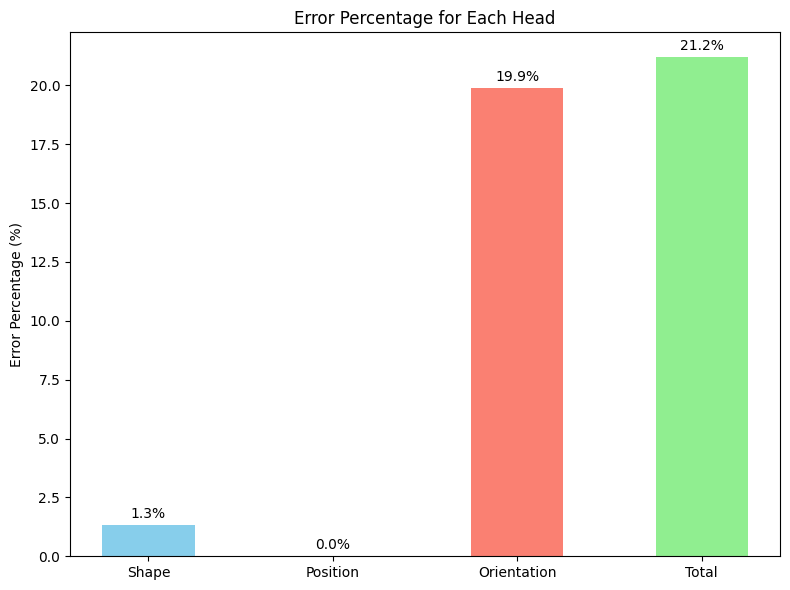

In [34]:
## Testing
# Load the best model
model_path = '4M25_modelling/trained_models/model_20250317_162245_13'
model.load_state_dict(torch.load(model_path))
print('Loaded model from', model_path)
model.eval()

# Test the model on the validation set
correct_shape = 0
correct_pos = 0
correct_or = 0
correct_total = 0
total = 0

test_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = True) # create dataloader for validation dataset

with torch.no_grad():
    for data in test_dataloader:
        readings, labels = data
        readings = readings.to(device)
        labels = labels.to(device)
        shape_labels = labels[:, 0]
        position_labels = labels[:, 1]
        orientation_labels = labels[:, 2]
                
        shape_logits, position_logits, orientation_logits = model(readings)
        
        _, shape_pred = torch.max(shape_logits, 1)
        _, position_pred = torch.max(position_logits, 1)
        _, orientation_pred = torch.max(orientation_logits, 1)
        
        total += labels.size(0)
        
        # evalute for each head and overall
        correct_shape += (shape_pred == shape_labels).sum().item()
        correct_pos += (position_pred == position_labels).sum().item()
        correct_or += (orientation_pred == orientation_labels).sum().item()
        
        # overall accuracy
        correct_total += ((shape_pred == shape_labels) & (position_pred == position_labels) & (orientation_pred == orientation_labels)).sum().item()
        
# print accuracy for each head and overall
acc_shape = 100 * correct_shape / total
acc_pos = 100 * correct_pos / total
acc_or = 100 * correct_or / total

acc_total = 100 * correct_total / total

print(f'Shape accuracy: {acc_shape:.2f}%')
print(f'Position accuracy: {acc_pos:.2f}%')
print(f'Orientation accuracy: {acc_or:.2f}%')
print(f'Overall accuracy: {acc_total:.2f}%')

# Plot the error percentages for each head
# Define the heads and their error percentages
heads = ['Shape', 'Position', 'Orientation', 'Total']
error_percentages = [100 - acc_shape, 100 - acc_pos, 100 - acc_or, 100 - acc_total]

# X-axis positions for the bars
x = np.arange(len(heads))
width = 0.5

# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(x, error_percentages, width, color=['skyblue', 'steelblue', 'salmon', 'lightgreen'])

# Add labels above each bar indicating the error percentage
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Set labels and title
ax.set_ylabel('Error Percentage (%)')
ax.set_title('Error Percentage for Each Head')
ax.set_xticks(x)
ax.set_xticklabels(heads)

plt.tight_layout()
plt.show()


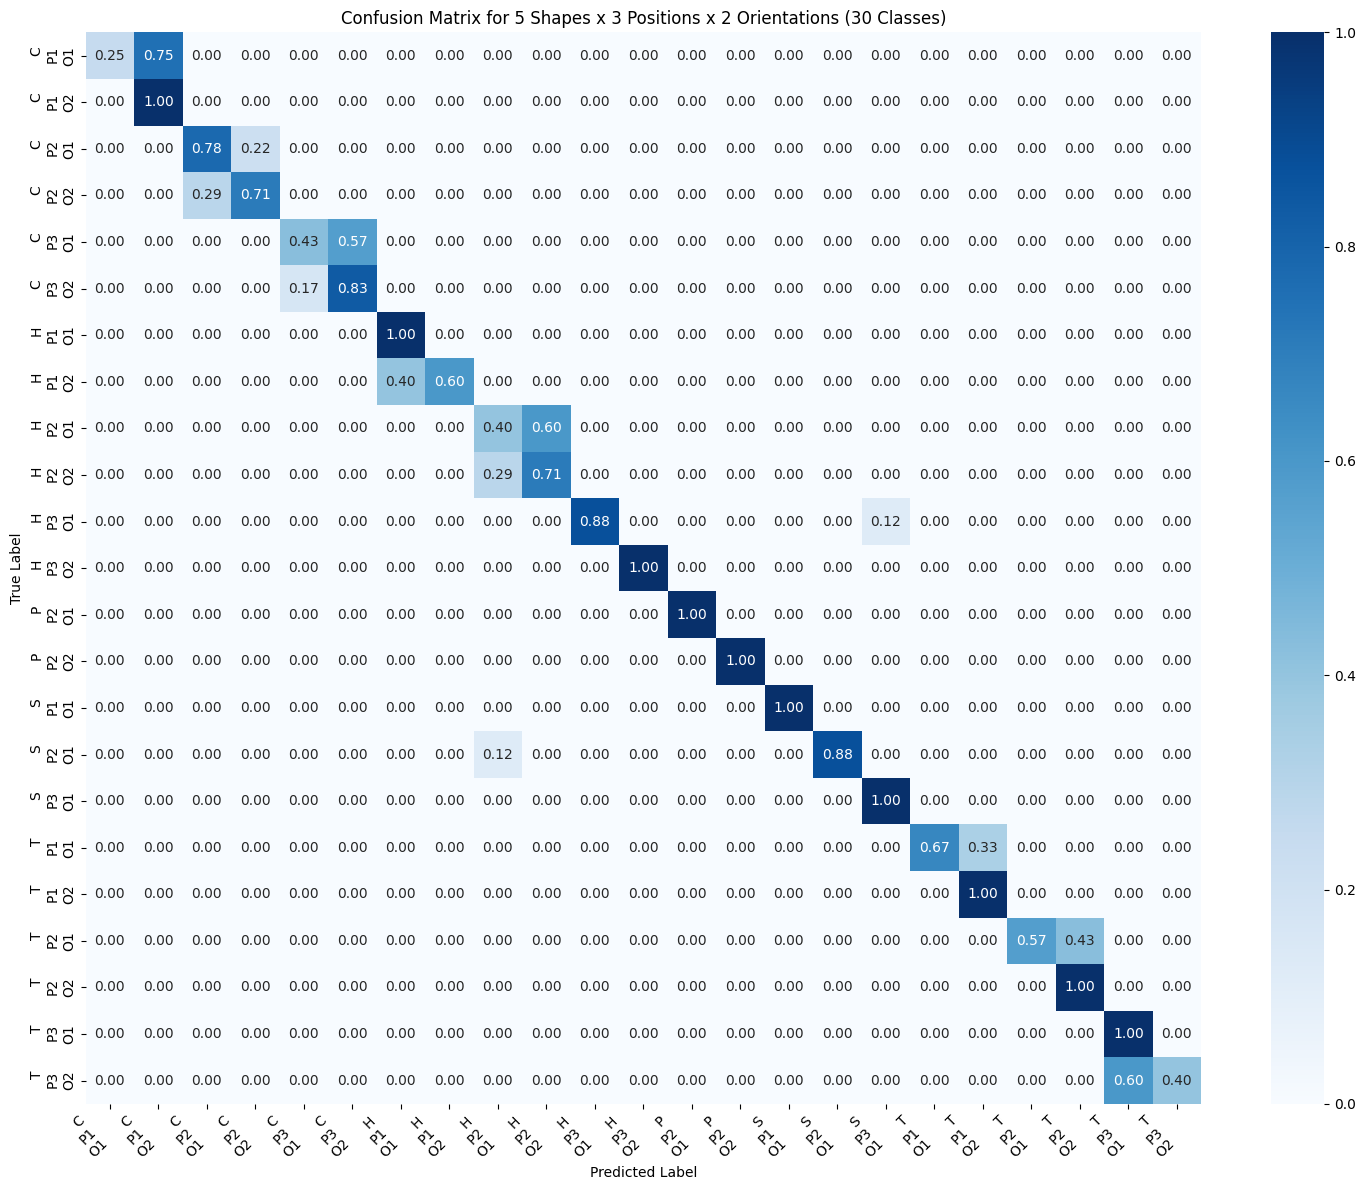

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define class parameters
shapes = ['C', 'H', 'P', 'S', 'T']
positions = ['P1', 'P2', 'P3']
orientations = ['O1', 'O2']

# Create human-friendly labels for each of the 30 classes
class_labels = [f'{s}\n{p}\n{o}' for s in shapes for p in positions for o in orientations]
num_classes = len(class_labels)  # should be 30

num_samples = len(val_dataset)
y_true = np.empty(0, dtype=int)
y_pred = np.empty(0, dtype=int)

test_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = True) # create dataloader for validation dataset

with torch.no_grad():
    for data in test_dataloader:
        readings, labels = data
        readings = readings.to(device)
        labels = labels.to(device)
        shape_labels = labels[:, 0]
        position_labels = labels[:, 1]
        orientation_labels = labels[:, 2]
                
        shape_logits, position_logits, orientation_logits = model(readings)
        
        _, shape_pred = torch.max(shape_logits, 1)
        _, position_pred = torch.max(position_logits, 1)
        _, orientation_pred = torch.max(orientation_logits, 1)
        
        # combine the three predictions into a single class label for confusion matrix
        y_true = np.append(y_true, shape_labels.item() * 6 + position_labels.item() * 2 + orientation_labels.item())
        y_pred = np.append(y_pred, shape_pred.item() * 6 + position_pred.item() * 2 + orientation_pred.item())

cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

# Identify indices of classes that appear in the ground truth (i.e., rows with non-zero sum)
nonzero_indices = np.where(cm.sum(axis=1) != 0)[0]

# Filter the confusion matrix and class labels to exclude classes with all zeros
cm_filtered = cm[np.ix_(nonzero_indices, nonzero_indices)]
class_labels_filtered = [class_labels[i] for i in nonzero_indices]

# Normalize the filtered confusion matrix (each row sums to 1)
cm_normalized = cm_filtered.astype('float') / cm_filtered.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels_filtered, yticklabels=class_labels_filtered)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for 5 Shapes x 3 Positions x 2 Orientations (30 Classes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
